In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt

import sys  
sys.path.insert(0, '../fraud-detector/')
from feateng import FeatPipeline

In [2]:

###############################
# Variable Assignment and data read in
###############################
#TODO: make configurable
sampleRate = 0.1
raw = pd.read_csv("../data/input_data.csv").drop(columns = ["isFlaggedFraud"])
raw_sampled = pd.DataFrame.sample(raw, frac = sampleRate)


In [3]:
df = FeatPipeline.fit_transform(raw_sampled)
print("Debugging log - FE step complete:")
df.head()

Debugging log - FE step complete:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,stepDay,stepHour,stepWeekDay,isDestMerchant,isDestBalanceNewZero,isDestBalanceOldZero,isOrigBalanceNewZero,isOrigBalanceOldZero
2319539,188,PAYMENT,29161.74,C1846003900,103893.72,74731.97,M1759469828,0.0,0.00,0,8.0,20.0,1.0,1,1,1,0,0
4176903,304,CASH_IN,376257.18,C1756642205,2654313.01,3030570.18,C1864446202,6688750.8,6312493.62,0,13.0,16.0,6.0,0,0,0,0,0
2761232,213,PAYMENT,9584.22,C324853722,12224.00,2639.78,M72951935,0.0,0.00,0,9.0,21.0,2.0,1,1,1,0,0
2766156,213,PAYMENT,33856.69,C1226196537,74391.38,40534.69,M1488066838,0.0,0.00,0,9.0,21.0,2.0,1,1,1,0,0
5531538,381,PAYMENT,20711.66,C1652492236,78496.34,57784.68,M272795127,0.0,0.00,0,16.0,21.0,2.0,1,1,1,0,0


In [4]:
###############################
# More variable Assignment
###############################
#TODO: make configurable
target_feature = ["isFraud"]
id_features = ['nameDest', 'nameOrig']

all_features = df.columns.difference(target_feature).difference(id_features)
all_features

Index(['amount', 'isDestBalanceNewZero', 'isDestBalanceOldZero',
       'isDestMerchant', 'isOrigBalanceNewZero', 'isOrigBalanceOldZero',
       'newbalanceDest', 'newbalanceOrig', 'oldbalanceDest', 'oldbalanceOrg',
       'step', 'stepDay', 'stepHour', 'stepWeekDay', 'type'],
      dtype='object')

In [5]:
y = df[target_feature]
X_train, X_test, y_train, y_test = train_test_split(df[all_features], np.array(df[target_feature]), test_size = 0.3,random_state=2, stratify=y)


In [6]:
# Generate roc_auc curves
roc_auc_train_df = pd.DataFrame(columns=[
       'features', 'logistic_regression', 'random_forest', 'gradient_boosting',
])

roc_auc_test_df = pd.DataFrame(columns=[
       'features', 'logistic_regression', 'random_forest', 'gradient_boosting'
])

for i in range(len(all_features)):
    try:
        lr = joblib.load(f'../models/logisticRegression_{i + 1}.pkl')
        rf = joblib.load(f'../models/randomForest_{i + 1}.pkl')
        gb = joblib.load(f'../models/gradientBoosting_{i + 1}.pkl')

        features = all_features[:i + 1]
        print("Iteration " + str(i) + ", features: ", features)

        # roc auc - train data
        lr_roc_auc_score_train = roc_auc_score(y_train, lr.predict_proba(X_train)[:, 1])
        gb_roc_auc_score_train = roc_auc_score(y_train, gb.predict_proba(X_train)[:, 1])
        rf_roc_auc_score_train = roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1])
        roc_auc_train_df.loc[len(roc_auc_test_df)] = [
               i + 1, lr_roc_auc_score_train, rf_roc_auc_score_train, gb_roc_auc_score_train
        ]

        # roc auc - test data
        lr_roc_auc_score_test = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])
        gb_roc_auc_score_test = roc_auc_score(y_test, gb.predict_proba(X_test)[:, 1])
        rf_roc_auc_score_test = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
        roc_auc_test_df.loc[len(roc_auc_test_df)] = [
               i + 1, lr_roc_auc_score_test, rf_roc_auc_score_test, gb_roc_auc_score_test
        ]
    except:
        pass


Iteration 0, features:  Index(['amount'], dtype='object')
Iteration 1, features:  Index(['amount', 'isDestBalanceNewZero'], dtype='object')
Iteration 2, features:  Index(['amount', 'isDestBalanceNewZero', 'isDestBalanceOldZero'], dtype='object')
Iteration 3, features:  Index(['amount', 'isDestBalanceNewZero', 'isDestBalanceOldZero',
       'isDestMerchant'],
      dtype='object')
Iteration 4, features:  Index(['amount', 'isDestBalanceNewZero', 'isDestBalanceOldZero',
       'isDestMerchant', 'isOrigBalanceNewZero'],
      dtype='object')
Iteration 5, features:  Index(['amount', 'isDestBalanceNewZero', 'isDestBalanceOldZero',
       'isDestMerchant', 'isOrigBalanceNewZero', 'isOrigBalanceOldZero'],
      dtype='object')
Iteration 6, features:  Index(['amount', 'isDestBalanceNewZero', 'isDestBalanceOldZero',
       'isDestMerchant', 'isOrigBalanceNewZero', 'isOrigBalanceOldZero',
       'newbalanceDest'],
      dtype='object')
Iteration 7, features:  Index(['amount', 'isDestBalanceNewZer

In [7]:
roc_auc_train_df



,features,logistic_regression,random_forest,gradient_boosting
0,1.0,0.785483,0.791682,0.789626
1,2.0,0.785483,0.790768,0.789626
2,3.0,0.785483,0.790991,0.789626
3,4.0,0.797560,0.811725,0.828375
4,5.0,0.797560,0.810401,0.828375
5,6.0,0.797560,0.802899,0.828375
6,7.0,0.872600,0.911510,0.789042
7,8.0,0.891248,0.955823,0.930705
8,9.0,0.891623,0.951269,0.947330
9,10.0,0.904144,0.998661,0.979778


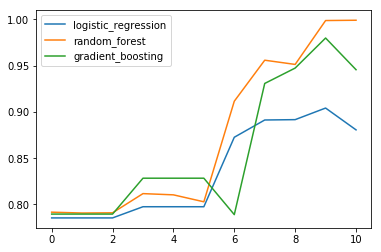

In [8]:
roc_auc_train_df[[col for col in roc_auc_train_df.columns if col not in ['features']]].plot();


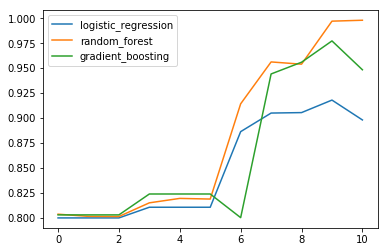

In [9]:
roc_auc_test_df[[col for col in roc_auc_test_df.columns if col not in ['features']]].plot();


In [10]:
roc_auc_test_df['gb_diff'] = roc_auc_test_df['gradient_boosting'] - roc_auc_test_df['gradient_boosting'].shift(1)
roc_auc_test_df['rf_diff'] = roc_auc_test_df['random_forest'] - roc_auc_test_df['random_forest'].shift(1)
roc_auc_test_df[['features', 'gradient_boosting', 'random_forest', 'gb_diff', 'rf_diff']]



,features,gradient_boosting,random_forest,gb_diff,rf_diff
0,1.0,0.802810,0.803506,NaN,NaN
1,2.0,0.802810,0.801334,0.000000,-0.002172
2,3.0,0.802810,0.801172,0.000000,-0.000163
3,4.0,0.823762,0.814898,0.020952,0.013726
4,5.0,0.823762,0.819338,0.000000,0.004440
5,6.0,0.823762,0.818688,0.000000,-0.000650
6,7.0,0.800047,0.914215,-0.023715,0.095528
7,8.0,0.944155,0.956213,0.144108,0.041998
8,9.0,0.955914,0.953953,0.011759,-0.002260
9,10.0,0.977292,0.997111,0.021378,0.043157


## Pick a model type

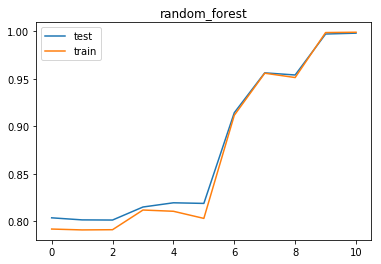

In [11]:
# Compare roa_auc on train vs test set
model_type = "random_forest" #["logistic_regression", gradient_boosting", "random_forest"]

plt.plot(roc_auc_test_df[model_type], label = 'test');
plt.plot(roc_auc_train_df[model_type], label = 'train');
plt.legend(loc = 'best');
plt.title(model_type);



# Now pick a model

In [12]:
# Choose model: 
model_chosen = 'randomForest_10' #["gradientBoosting", logisticRegression", "randomForest"]
model = joblib.load(f'../models/{model_chosen}.pkl')
y_test_pred = model.predict(X_test)
y_test_pred_proba = model.predict_proba(X_test)
y_test_pred_proba_posit = y_test_pred_proba[:, 1]

In [13]:
# select features of interest
model.predict(df[all_features])
model.predict_proba(df[all_features])[:,1]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 6.58729709e-05])

190639 240
Confusion matrix
[[190631      8]
 [    66    174]]
Normalized confusion matrix
[[9.99958036e-01 4.19641312e-05]
 [2.75000000e-01 7.25000000e-01]]


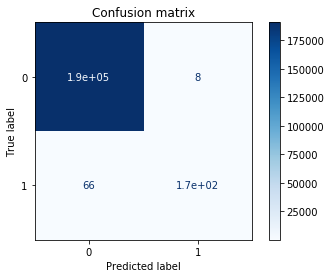

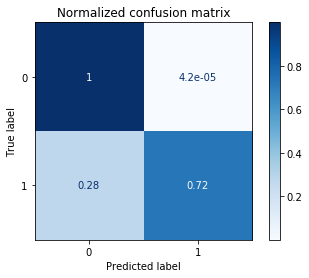

In [14]:
y_test_zeros = pd.DataFrame(y_test)[0].value_counts()[0]
y_test_ones = pd.DataFrame(y_test)[0].value_counts()[1]
print(y_test_zeros, y_test_ones)

from sklearn.metrics import plot_confusion_matrix
titles_options = [("Confusion matrix", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)




Text(0.5, 1.0, '2-class Precision-Recall curve: Average Precision=0.00')

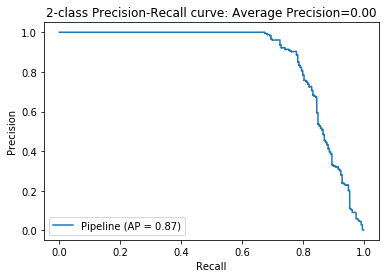

In [15]:
# PR curve focuses on the minority class, whereas the ROC curve covers both classes.
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

average_precision = average_precision_score(y_test, y_test_pred_proba[:,0])


disp = plot_precision_recall_curve(model, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'Average Precision={0:0.2f}'.format(average_precision))

Counter({0: 190697, 1: 182})


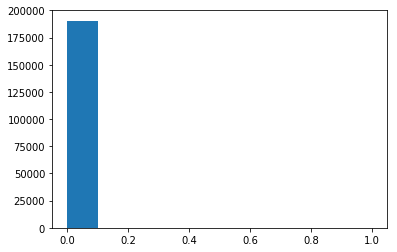

,pred,pred_prob
589,1,1.000000
2092,1,0.590989
2735,1,1.000000
4033,1,0.550793
5908,1,1.000000


In [16]:
# summarize the distribution of class labels
from collections import Counter
print(Counter(y_test_pred))
# create a histogram of the predicted probabilities of fraud = 1
plt.hist(y_test_pred_proba[:,1], bins=10)
plt.show()

y_pred_df = pd.concat([pd.DataFrame(y_test_pred), pd.DataFrame(y_test_pred_proba[:,1])], axis=1)
y_pred_df.columns = ["pred", "pred_prob"]

y_pred_df[y_pred_df["pred"]==1].head()



In [17]:
y_pred_df.head()

,pred,pred_prob
0,0,0.000416
1,0,0.000178
2,0,0.000004
3,0,0.010003
4,0,0.000000


## Potential solutions to highly imbalanced data:
- Over/undersampling strategies
- Ideally, we would want the business to provide or help us estimate the cost of failing to detect a case of fraud (False Negative) or flagging as such a transaction that is instead genuine (False Positive). We can then use this to build a **loss function** that can be passed to the model, either for training stage (ideal, see here: https://towardsdatascience.com/custom-loss-functions-for-gradient-boosting-f79c1b40466d) or for hyper-parameter tuning.



In [18]:
## UDF for scoring in Spark
# from dna_utils import SparkConfig
# spark = SparkConfig(app_name="modelling",).connect()

# train_df = pd.DataFrame(columns = [
#     'features', 'logistic_regression', 'gradient_boosting', 'random_forest'
# ])

# test_df = pd.DataFrame(columns = [
#     'features', 'logistic_regression', 'gradient_boosting', 'random_forest'
# ])

# for i in range(len(all_features)):
#     lr = joblib.load(f'../models/logisticRegression_{i+1}.pkl')
#     gb = joblib.load(f'../models/gradientBoosting_{i+1}.pkl')
#     rf = joblib.load(f'../models/randomForest_{i+1}.pkl')

#     features = all_feats[:i+1]

#     logistic_regression = roc_auc_score(y_train, lr.predict_proba(X_train)[:, 1])
#     gradient_boosting = roc_auc_score(y_train, gb.predict_proba(X_train)[:, 1])
#     random_forest = roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1])

#     train_df.loc[len(train_df)] = [
#         i + 1, logistic_regression, gradient_boosting, random_forest
#     ]


#     @F.pandas_udf(returnType = T.ArrayType(T.DoubleType()))
#     def predict_lr(*cols):
#         X = pd.concat(cols, axis = 1)
#         return pd.Series(row.tolist() for row in lr.predict_proba(X))

#     @F.pandas_udf(returnType = T.ArrayType(T.DoubleType()))
#     def predict_gb(*cols):
#         X = pd.concat(cols, axis = 1)
#         return pd.Series(row.tolist() for row in gb.predict_proba(X))

#     @F.pandas_udf(returnType = T.ArrayType(T.DoubleType()))
#     def predict_rf(*cols):
#         X = pd.concat(cols, axis = 1)
#         return pd.Series(row.tolist() for row in rf.predict_proba(X))

#     df2 = spark.createDataFrame(df)\
#         .withColumn('lrPrediction', predict_lr(*features))\
#         .withColumn('gbPrediction', predict_gb(*features))\
#         .withColumn('rfPrediction', predict_rf(*features))\
#         [['target',
#           F.col('lrPrediction')[1].alias('lr_prediction'),
#           F.col('gbPrediction')[1].alias('gb_prediction'),
#           F.col('rfPrediction')[1].alias('rf_prediction')
#          ]]\
#         .toPandas()

#     logistic_regression_test = roc_auc_score(df2['target'], df2['lr_prediction'])
#     gradient_boosting_test = roc_auc_score(df2['target'], df2['gb_prediction'])
#     random_forest_test = roc_auc_score(df2['target'], df2['rf_prediction'])

#     test_df.loc[len(test_df)] = [
#         i + 1, gradient_boosting_test, random_forest_test, logistic_regression_test
#     ]

#     print(i + 1, ' done')